## Multiobjective Evolutionary Algorithm based on Decomposition (MOEA/D)

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [5]:
def uniform_vector(N):
    ys = -np.log(np.random.uniform(size = N))
    return ys/sum(ys)

In [6]:
def init_weights(N, point, delta):
    lambdas1 = np.random.uniform(point -delta, point + delta, N)
    lambdas = np.concatenate([[lambdas1], [1 - lambdas1]], axis = 0).T
    return lambdas

In [7]:
def init_neighbourhood(lambdas, N, T):
    neighbourhood =  np.array([None] * N)
    for i in range(N):
        all_distances = [None] * N
        for j in range(N):
            all_distances[j] = ([np.linalg.norm(lambdas[i] - lambdas[j]), j])
        all_distances = np.array(all_distances)
        neighbourhood[i] = all_distances[:, 0].argsort()[1: T + 1]  
    return neighbourhood

In [8]:
def confidence_interval(data, p):
    return st.norm.interval(alpha = p, loc = np.mean(data), scale = data.std())

In [9]:
def init_z(data, x0, N, n_objectives, probabilities):
    znad = np.array([None] * n_objectives)
    z = np.array([None] * n_objectives)
    for j in range(n_objectives):
        alphas = np.array([None] * N)
        betas = np.array([None] * N)
        for i in range(N):
            interval = confidence_interval(np.dot(data, x0[i]), probabilities[j])
            alphas[i] = interval[0]
            betas[i] = interval[1]
        znad[j] = min(alphas)
        z[j] = max(betas)
    return znad, z

In [10]:
def check_solution(x, epsilon):
    scale = abs(sum(x) - 1) < 0.0001
    boundaries = (x < epsilon).all()
    return scale and boundaries

In [11]:
def theta(data, x, pr):
    return np.array(confidence_interval(np.dot(data, x), pr))    

In [12]:
def compare_intervals(i, j):
    p = (i[1] - j[0]) / (i[1] - i[0] + j[1] - j[0])
    if p > 1:
        return 1
    elif p < 0:
        return 0
    else:
        return p

In [13]:
N = 100
T = 20
stocks = 31
n_objectives = 2
delta = 0.9
pm = 0.01
epsilon = 0.4
nr = 2

In [14]:
def moead(returns, x0, N, T, n_objectives, probabilities):
    x = x0.copy()
    znad, z = init_z(returns, x0, N, n_objectives, probabilities)
    for interation in range(100):
        for i in range(N):
            first_step = True
            while first_step or not check_solution(y, epsilon):
                if np.random.uniform() < delta:
                    p = neighbourhood[i]
                else:
                    p = range(N)
                r1 = i
                r2, r3 = np.random.choice(p, 2)
                y = (x[r1] + x[r2] + x[r3]) / 3
                if np.random.uniform() < pm:
                    j, jj = np.random.choice(range(stocks), 2)
                    y[j], y[jj] = y[jj], y[j]

                y = y/sum(y)
                first_step = False

            for j in range(n_objectives):
                interval = theta(returns, y, probabilities[j])
                znad[j] = min(znad[j], interval[0])
                z[j] = max(z[j], interval[1])

            c = 0
            while c < nr and len(p) != 0:
                ii = np.random.choice(p)
                intervals = np.array([None] * n_objectives)
                intervals_y = np.array([None] * n_objectives)
                for j in range(n_objectives):
                    interval = theta(returns, x[ii], probabilities[j])

                    interval_y = theta(returns, y, probabilities[j])

                    alpha_norm = (interval[0] - znad[j])/(z[j] - znad[j])
                    beta_norm = (interval[1] - znad[j])/(z[j] - znad[j])

                    alpha_norm_y = (interval_y[0] - znad[j])/(z[j] - znad[j])
                    beta_norm_y = (interval_y[1] - znad[j])/(z[j] - znad[j])

                    intervals[j] = np.array([1 - beta_norm, 1 - alpha_norm]) * lambdas[ii][j]
                    intervals_y[j] = np.array([1 - beta_norm_y, 1 - alpha_norm_y]) * lambdas[i][j]
                if compare_intervals(intervals[0], intervals[-1]) >= 0.5:
                    g = intervals[0]
                else:
                    g = intervals[-1]

                if compare_intervals(intervals_y[0], intervals_y[-1]) >= 0.5:
                    g_y = intervals_y[0]
                else:
                    g_y = intervals_y[-1]

                if compare_intervals(g_y, g) >= 0.5:
                    x[ii] = y
                    c += 1
                p = np.delete(p, np.argwhere(p == ii))
                
    return x

## example

In [ ]:
#initial solution and weights
lambdas = init_weights(N, 0.7, 0.1)
neighbourhood = init_neighbourhood(lambdas, N, T)
x0 = np.array([uniform_vector(stocks) for _ in range(N)])

x95_75 = moead(normalized_returns, x0, N, T, n_objectives, [0.95, 0.75])
max1 = np.argmax(np.array([theta(returns, x95_75[i], [0.95, 0.75]).T[0] for i in range(100)]).mean(axis = 1))

x50_30 = moead(normalized_returns, x0, N, T, n_objectives, [0.5, 0.3])
max2 = np.argmax(np.array([theta(returns, x50_30[i], [0.5, 0.3]).T[0] for i in range(100)]).mean(axis = 1))

## cumlative return comparison

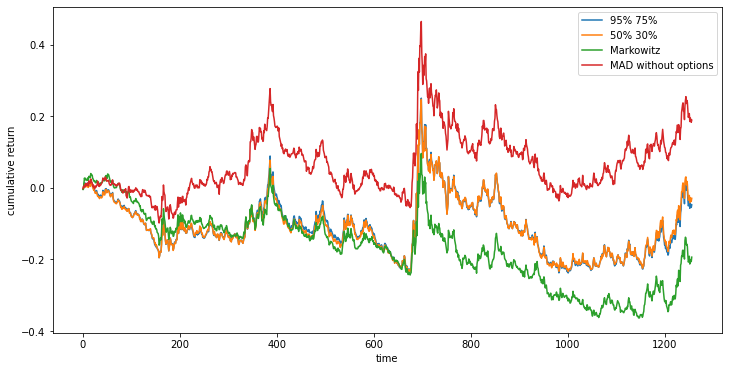

In [204]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(np.dot(returns, part95_75[partmax1])), label = "95% 75%")
plt.plot(np.cumsum(np.dot(returns, part50_30[partmax2])),label = "50% 30%")
plt.plot(np.cumsum(np.dot(returns, opt.x)), label = "Markowitz")
plt.plot(np.cumsum(np.dot(returns, ws)), label = "MAD without options")
plt.xlabel("time")
plt.ylabel("cumulative return")
plt.legend()
plt.show()

## efficient frontier (without short sales)

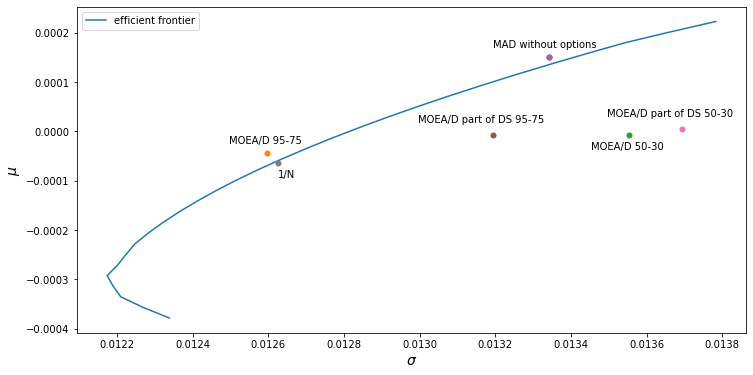

In [98]:
plt.figure(figsize=(12, 6))

plt.plot(stds2[25:54], mus2[25:54], label = "efficient frontier")
plt.plot(np.sqrt(sigma95_75), mu95_75,marker="o", markersize=5)
plt.plot(np.sqrt(sigma50_30), mu50_30,marker="o", markersize=5)
plt.plot(np.sqrt(sigma_mad), mu_mad,marker="o", markersize=5)

plt.plot(np.sqrt(sigma_madlong), mu_madlong,marker="o", markersize=5)

plt.plot(np.sqrt(sigma_part95_75), mu_part95_75,marker="o", markersize=5)
plt.plot(np.sqrt(sigma_part50_30), mu_part50_30,marker="o", markersize=5)

plt.plot(np.sqrt(sigma_naive), mu_naive, marker = "o", markersize=5)

plt.xlabel(r'$\sigma$', fontsize = 14)
plt.ylabel(r'$\mu$', fontsize = 14)

plt.annotate("MOEA/D 95-75", (np.sqrt(sigma95_75)-0.0001, mu95_75+0.00002))
plt.annotate("MOEA/D 50-30", (np.sqrt(sigma50_30)-0.0001, mu50_30-0.00003))
plt.annotate("MOEA/D part of DS 95-75", (np.sqrt(sigma_part95_75)-0.0002, mu_part95_75+0.000025))
plt.annotate("MOEA/D part of DS 50-30", (np.sqrt(sigma_part50_30)-0.0002, mu_part50_30+0.000025))
#plt.annotate("MAD without options + short sales", (np.sqrt(sigma_mad)-0.0001, mu_mad+0.00002))
plt.annotate("MAD without options", (np.sqrt(sigma_madlong)-0.00015, mu_madlong+0.00002))
plt.annotate("1/N", (np.sqrt(sigma_naive), mu_naive-0.00003))

plt.legend()
plt.show()